In [5]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
from lmfit import Model,Minimizer
import corner
import numdifftools

In [6]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler

In [516]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];
wdtable = Table.read('wdtable.fits')
good = (
    (wdtable['centre_beta'] < hbeta + 1)*
    (wdtable['centre_beta'] > hbeta - 1)*
    (wdtable['centre_alpha'] > halpha - 1)*
    (wdtable['centre_alpha'] < halpha + 1) * 
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 15000) * 
    (wdtable['TeffH'] < 80000) * 
    (wdtable['s2n'] > 7)
)
wdtable = wdtable[good]

searchparameter = list(wdtable['specnames'])

## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,7000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)


 44%|████▍     | 308/703 [00:23<00:33, 11.80it/s]


 88%|████████▊ | 616/703 [00:47<00:07, 11.75it/s]


100%|██████████| 703/703 [00:55<00:00, 12.70it/s]

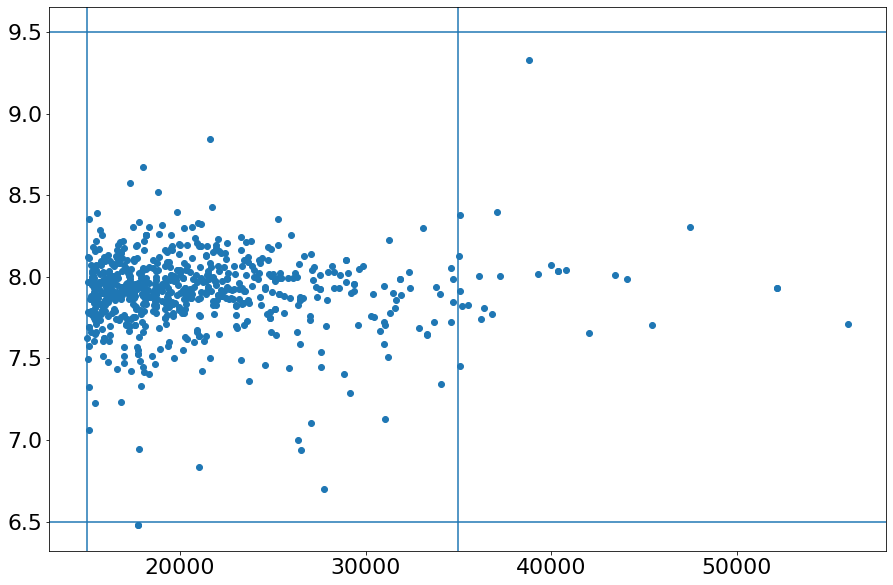

In [518]:
plt.scatter(TeffHs,loggHs)
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(15000)
plt.axvline(35000)

In [519]:
lam = np.arange(4000,7000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3):
    return c1 + c2*array + c3*array**2

In [576]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10)# + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10) \
            #+ (lamgrid > 7000)
    contcorr[skylinemask] = 1
    normspec.append(contcorr)
normspec = np.asarray(normspec)
len(normspec)


100%|██████████| 703/703 [00:00<00:00, 1198.42it/s]

703

In [619]:
sc = StandardScaler()

X = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())
t = normspec

In [623]:
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1)

In [629]:
def v_mse(y_true,y_pred):
    return K.mean(K.sum((1e5*y_pred-1e5*y_true)**2))


def generator():
    x = Input(shape=X[0].shape)
    y = Dense(10,activation='sigmoid')(x)
    y = Dense(10,activation='sigmoid')(y)
    out = Dense(3000,activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.1), loss = v_mse, \
                  metrics = ['mean_absolute_percentage_error'])
    return model

In [630]:
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_153 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_154 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_155 (Dense)            (None, 3000)              33000     
Total params: 33,140
Trainable params: 33,140
Non-trainable params: 0
_________________________________________________________________
None


In [631]:
epoch = 100
batch = 64

history = model.fit(X_train,y_train,epochs=epoch,verbose=2,batch_size=batch,validation_data = (X_test,y_test))

Train on 632 samples, validate on 71 samples
Epoch 1/100
 - 2s - loss: 465625498185676.1875 - mean_absolute_percentage_error: 43.0671 - val_loss: 259502089049506.2500 - val_mean_absolute_percentage_error: 39.9065
Epoch 2/100
 - 0s - loss: 113241114628355.2344 - mean_absolute_percentage_error: 22.7361 - val_loss: 79309368529415.2188 - val_mean_absolute_percentage_error: 21.6977
Epoch 3/100
 - 0s - loss: 34699534836230.4844 - mean_absolute_percentage_error: 12.4581 - val_loss: 21171993682496.9023 - val_mean_absolute_percentage_error: 10.4361
Epoch 4/100
 - 0s - loss: 13044912740637.1641 - mean_absolute_percentage_error: 7.5718 - val_loss: 5823782938306.7041 - val_mean_absolute_percentage_error: 4.8914
Epoch 5/100
 - 0s - loss: 6553696153755.5439 - mean_absolute_percentage_error: 4.8922 - val_loss: 3365224116858.5913 - val_mean_absolute_percentage_error: 3.3962
Epoch 6/100
 - 0s - loss: 4407712742594.4307 - mean_absolute_percentage_error: 4.0103 - val_loss: 3828048781196.6196 - val_mean_a

Epoch 51/100
 - 0s - loss: 2712808396462.9873 - mean_absolute_percentage_error: 2.9206 - val_loss: 2867634784746.3662 - val_mean_absolute_percentage_error: 2.9410
Epoch 52/100
 - 0s - loss: 2689312632157.9746 - mean_absolute_percentage_error: 2.9053 - val_loss: 2827417821068.6196 - val_mean_absolute_percentage_error: 2.9131
Epoch 53/100
 - 0s - loss: 2664007028995.2407 - mean_absolute_percentage_error: 2.8907 - val_loss: 2801918065995.7183 - val_mean_absolute_percentage_error: 2.8958
Epoch 54/100
 - 0s - loss: 2707365022758.8857 - mean_absolute_percentage_error: 2.9163 - val_loss: 2884930895641.2393 - val_mean_absolute_percentage_error: 2.9238
Epoch 55/100
 - 0s - loss: 2708479559498.5317 - mean_absolute_percentage_error: 2.9183 - val_loss: 2899824130249.9155 - val_mean_absolute_percentage_error: 2.9317
Epoch 56/100
 - 0s - loss: 2775238836224.0000 - mean_absolute_percentage_error: 2.9492 - val_loss: 2887286659850.8169 - val_mean_absolute_percentage_error: 2.9324
Epoch 57/100
 - 0s - l

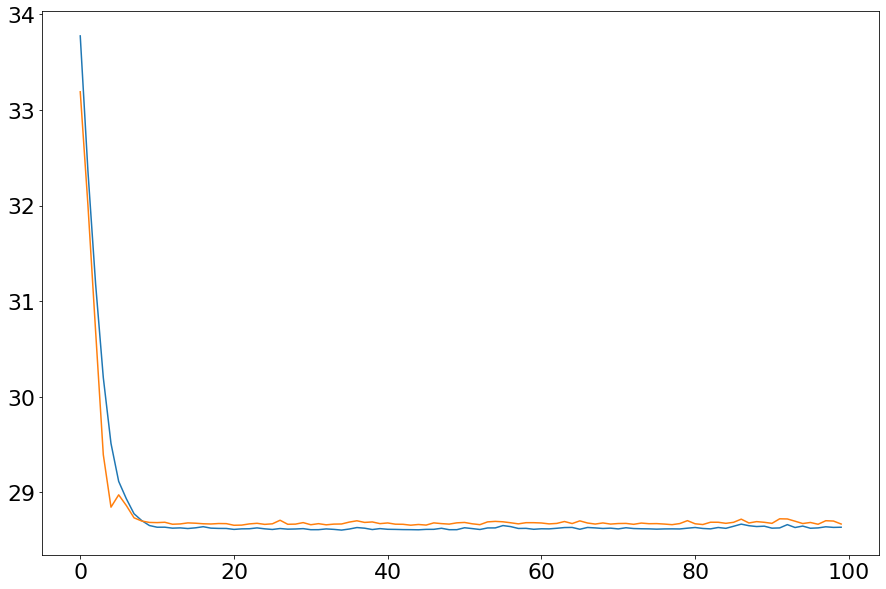

In [632]:
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))

In [633]:
preds = model.predict(X_test)

Text(0.5, 1.0, '0.01929364333995578')

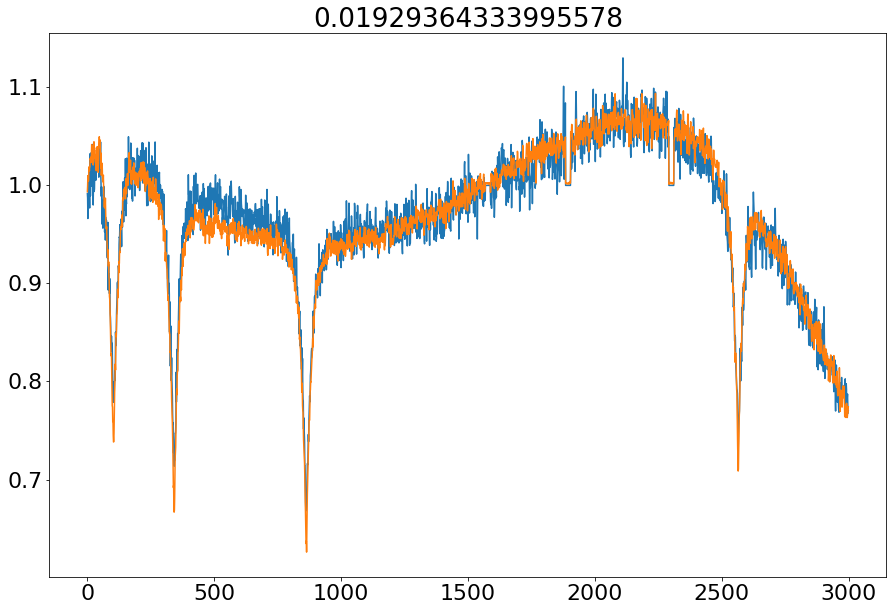

In [642]:
i = np.random.randint(len(X_test))
plt.plot(y_test[i])
plt.plot(preds[i])
error = np.sqrt(np.sum((y_test[i]-preds[i])**2/len(y_test[i])))
plt.title(str(error))

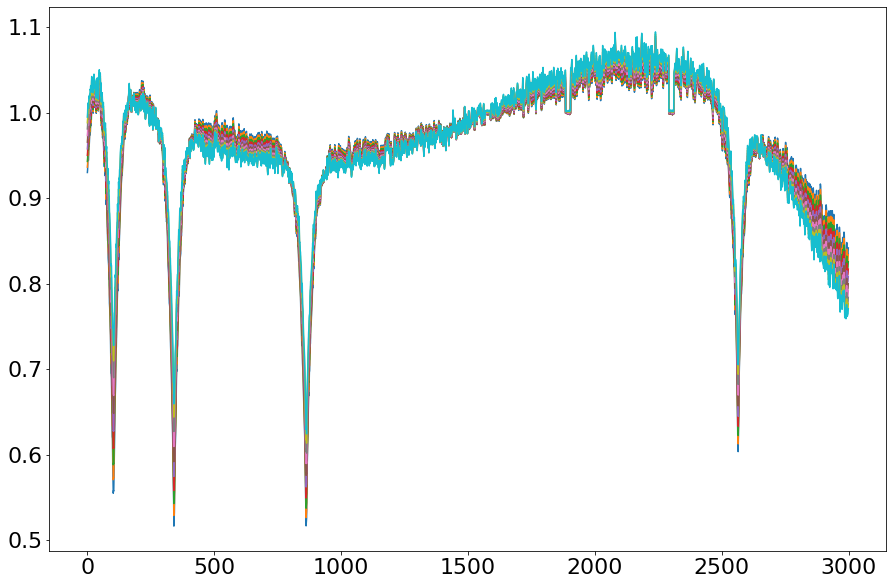

In [647]:
ts = np.linspace(15000,30000,10)
ls = np.linspace(6.5,7,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
plt.plot(gens.transpose());

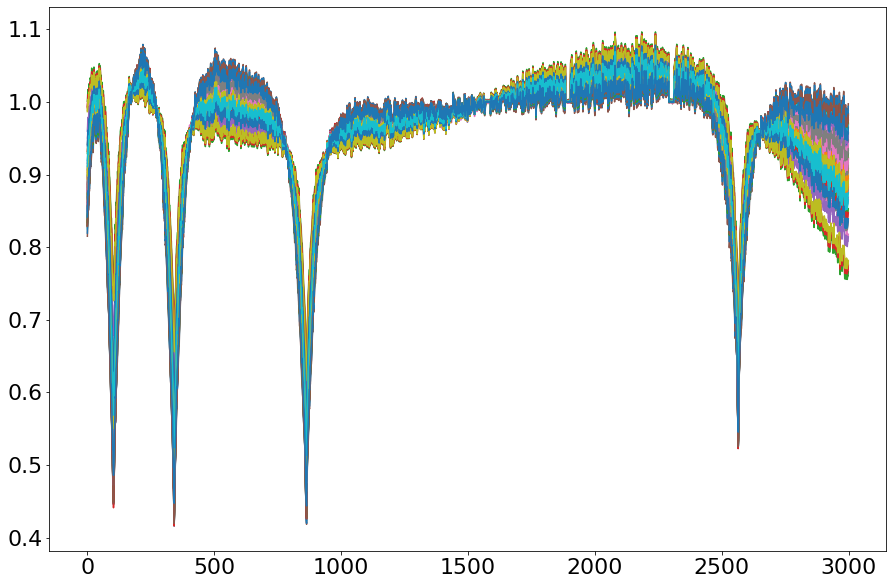

In [645]:
plt.plot(preds.transpose());

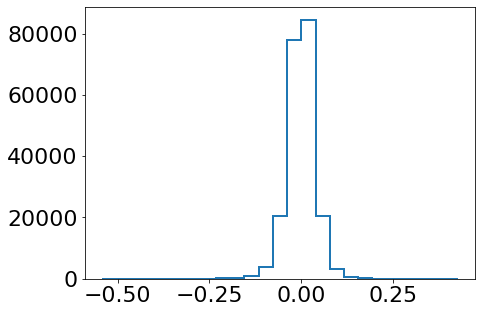

In [646]:
plt.figure(figsize=(7,5))
plt.hist(np.ravel(preds - y_test),bins = 25, histtype='step',linewidth = 2);

In [121]:
resids = y_test - preds

# Reverse

In [678]:
sc = StandardScaler()

cropped = normspec


X = cropped/np.max(X)
t = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())

In [679]:
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1)

In [680]:
def v_mse(y_true,y_pred):
    return K.mean(K.sum((1e5*y_pred-1e5*y_true)**2))


def generator():
    x = Input(shape=X[0].shape)
    y = Dense(10,activation='sigmoid')(x)
    y = Dense(10,activation='sigmoid')(y)
    out = Dense(2,activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.1), loss = v_mse, \
                  metrics = ['mean_absolute_percentage_error'])
    return model

In [681]:
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3000)              0         
_________________________________________________________________
dense_159 (Dense)            (None, 10)                30010     
_________________________________________________________________
dense_160 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_161 (Dense)            (None, 2)                 22        
Total params: 30,142
Trainable params: 30,142
Non-trainable params: 0
_________________________________________________________________
None


In [682]:
epoch = 100
batch = 64

history = model.fit(X_train,y_train,epochs=epoch,verbose=1,batch_size=batch,validation_data = (X_test,y_test))

Train on 632 samples, validate on 71 samples
Epoch 1/100
632/632 [==============================] - 2s 3ms/step - loss: 1380134043025.8228 - mean_absolute_percentage_error: 253.8989 - val_loss: 897441668773.8591 - val_mean_absolute_percentage_error: 143.6902
Epoch 2/100
632/632 [==============================] - 0s 52us/step - loss: 1318632043481.1140 - mean_absolute_percentage_error: 202.7172 - val_loss: 991847424576.9014 - val_mean_absolute_percentage_error: 144.4885
Epoch 3/100
632/632 [==============================] - 0s 48us/step - loss: 1307752435349.0632 - mean_absolute_percentage_error: 195.0178 - val_loss: 928784215083.2676 - val_mean_absolute_percentage_error: 104.7509
Epoch 4/100
632/632 [==============================] - 0s 48us/step - loss: 1283222977523.0381 - mean_absolute_percentage_error: 177.1090 - val_loss: 910426578597.8591 - val_mean_absolute_percentage_error: 113.8843
Epoch 5/100
632/632 [==============================] - 0s 51us/step - loss: 1274954885249.6204 -

Epoch 39/100
632/632 [==============================] - 0s 47us/step - loss: 1273007664685.3669 - mean_absolute_percentage_error: 153.3905 - val_loss: 909890785337.6902 - val_mean_absolute_percentage_error: 98.8057
Epoch 40/100
632/632 [==============================] - 0s 50us/step - loss: 1271549816365.3669 - mean_absolute_percentage_error: 148.2758 - val_loss: 904305508352.0000 - val_mean_absolute_percentage_error: 100.3507
Epoch 41/100
632/632 [==============================] - 0s 47us/step - loss: 1271230437038.9873 - mean_absolute_percentage_error: 124.1102 - val_loss: 912185651142.3098 - val_mean_absolute_percentage_error: 100.6997
Epoch 42/100
632/632 [==============================] - 0s 49us/step - loss: 1269755478016.0000 - mean_absolute_percentage_error: 123.1616 - val_loss: 910274148323.1549 - val_mean_absolute_percentage_error: 97.8765
Epoch 43/100
632/632 [==============================] - 0s 53us/step - loss: 1268330420923.9492 - mean_absolute_percentage_error: 104.5231

Epoch 77/100
632/632 [==============================] - 0s 51us/step - loss: 1266713925709.7722 - mean_absolute_percentage_error: 114.9673 - val_loss: 906253960091.0422 - val_mean_absolute_percentage_error: 101.5160
Epoch 78/100
632/632 [==============================] - 0s 56us/step - loss: 1266347313177.9241 - mean_absolute_percentage_error: 125.7409 - val_loss: 911462126317.9718 - val_mean_absolute_percentage_error: 99.8605
Epoch 79/100
632/632 [==============================] - 0s 56us/step - loss: 1268963258938.3291 - mean_absolute_percentage_error: 122.8684 - val_loss: 907971536809.4648 - val_mean_absolute_percentage_error: 98.9504
Epoch 80/100
632/632 [==============================] - 0s 52us/step - loss: 1262530136504.7090 - mean_absolute_percentage_error: 130.7815 - val_loss: 896411230092.6198 - val_mean_absolute_percentage_error: 104.0142
Epoch 81/100
632/632 [==============================] - 0s 53us/step - loss: 1271344975716.4556 - mean_absolute_percentage_error: 133.3853

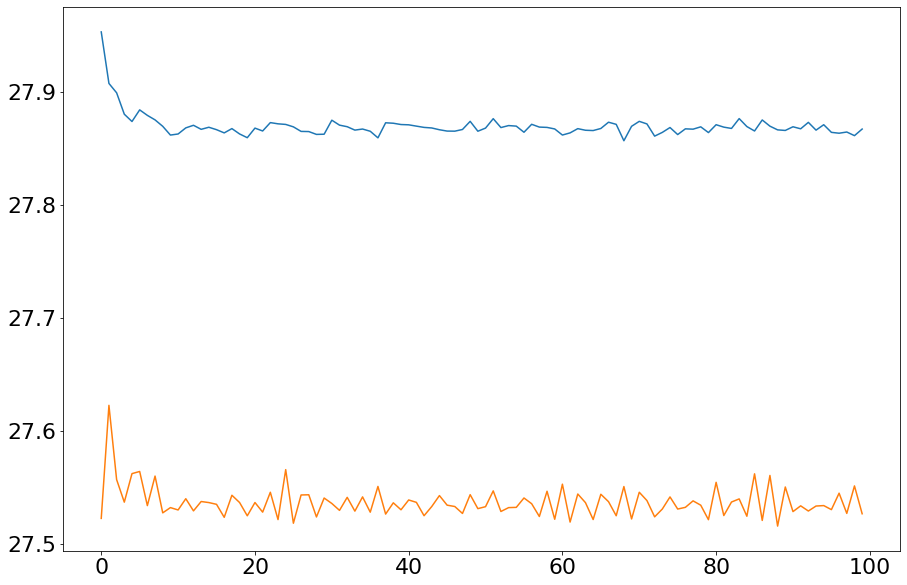

In [683]:
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))

In [684]:
preds = sc.inverse_transform(model.predict(X_train))
reals = sc.inverse_transform(y_train)

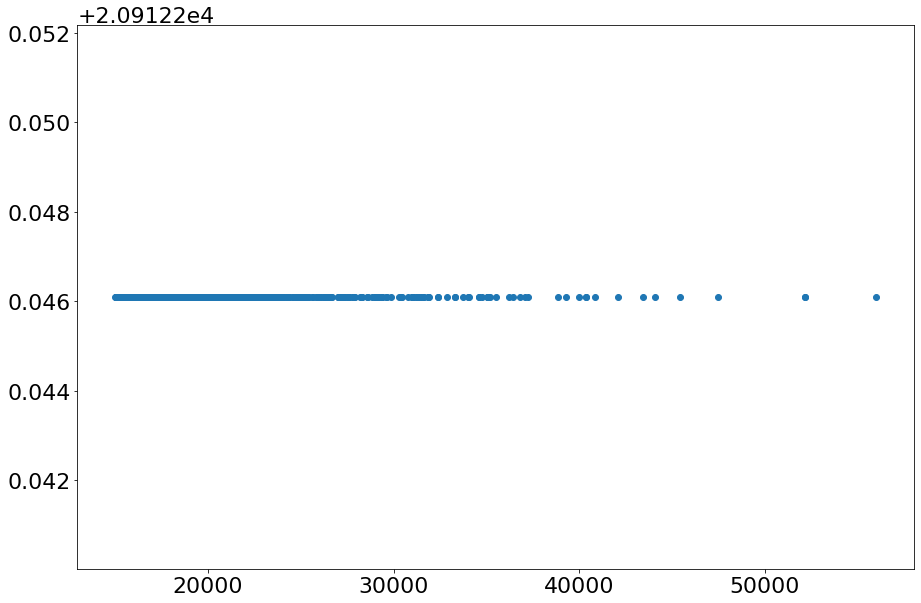

In [685]:
plt.scatter(reals[:,0],preds[:,0])

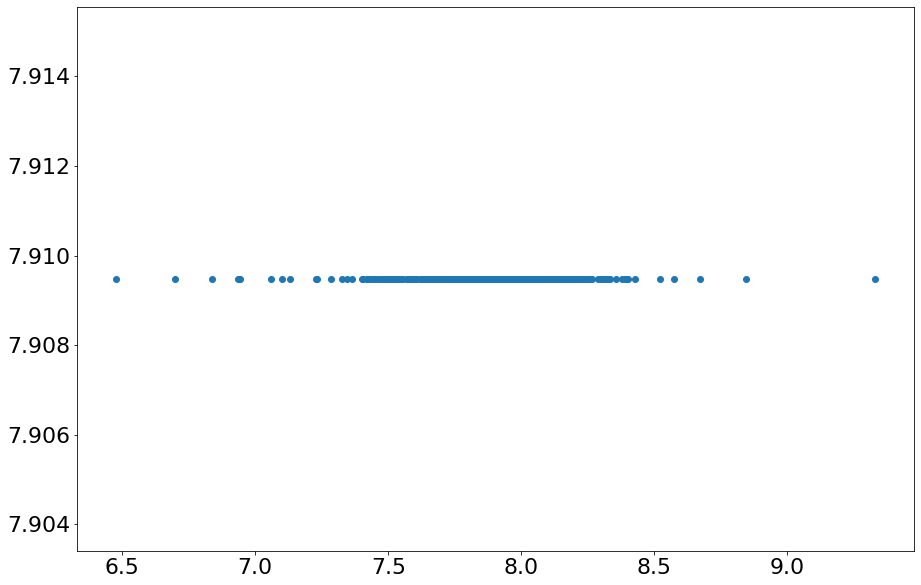

In [686]:
plt.scatter(reals[:,1],preds[:,1])

RMSE: 0.139
Error < 0.5 dex: 98.71 percent of the time.
Correlation: 0.315
RMSE: 0.075
Error < 1000 Kelvin: 100.00 percent of the time.
Correlation: 0.079


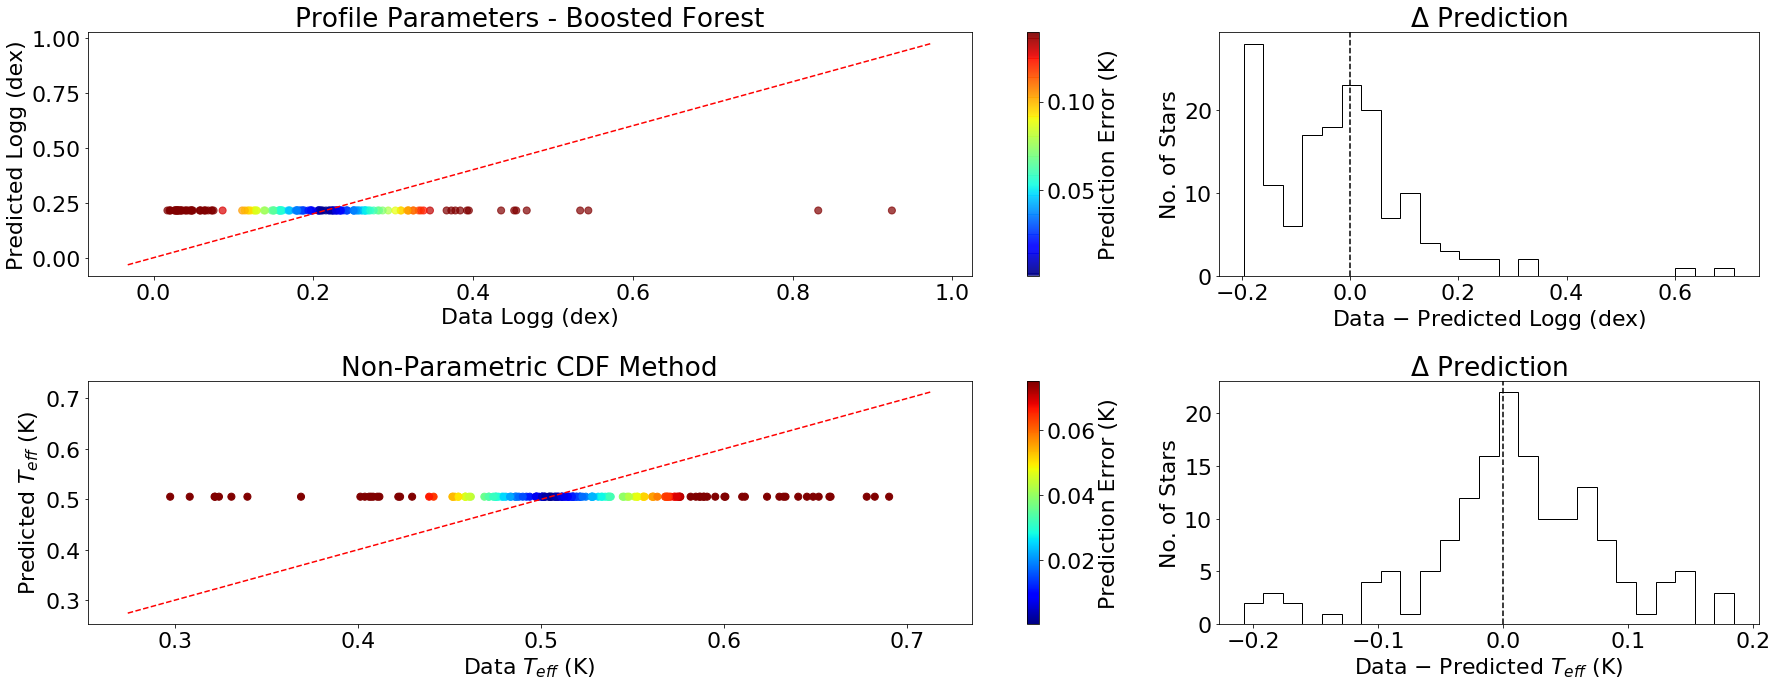

In [316]:
from matplotlib.pyplot import GridSpec

predictions = model.predict(X_test)


RMSE = np.sqrt( sum(((y_test[:,0]-predictions[:,0])**2)) / (len(y_test[:,0])))
fig = plt.figure(figsize=(25,10))
gs = GridSpec(2, 3, figure=fig)
fig.add_subplot(gs[0,0:2])
f=plt.scatter(y_test[:,0],predictions[:,0],c=np.abs(predictions[:,0]-y_test[:,0]),cmap='jet',vmax=RMSE,s=50,alpha=0.7)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Prediction Error (K)')
plt.xlabel('Data Logg (dex)')
plt.ylabel('Predicted Logg (dex)')
plt.title('Profile Parameters - Boosted Forest')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

fig.add_subplot(gs[0,2])


plt.hist(y_test[:,0]-predictions[:,0],bins=25,histtype='step',color='k');
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Data $-$ Predicted Logg (dex)')
plt.ylabel('No. of Stars');
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 0.5 dex: %.2f percent of the time.'\
%(100-(sum(abs(y_test[:,0]-predictions[:,0])>0.5))*100/len(y_test[:,0])))
plt.rcParams.update({'font.size': 22})

print('Correlation: %.3f'%np.corrcoef(y_test[:,0],predictions[:,0])[0,1])

RMSE = np.sqrt( sum(((y_test[:,1]-predictions[:,1])**2)) / (len(y_test[:,1])))
fig.add_subplot(gs[1,0:2])
#plt.errorbar(y_test[:,1],predictions[:,1],yerr=sigmas,linestyle="None",ecolor='k',marker="None", zorder=1)
f=plt.scatter(y_test[:,1],predictions[:,1],c=np.abs(predictions[:,1]-y_test[:,1]),cmap='jet',vmax=RMSE,s=50,zorder=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Prediction Error (K)')
plt.xlabel('Data $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Non-Parametric CDF Method')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

fig.add_subplot(gs[1,2])


plt.hist(y_test[:,1]-predictions[:,1],bins=25,histtype='step',color='k');
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Data $-$ Predicted $T_{eff}$ (K)')
plt.ylabel('No. of Stars');
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 1000 Kelvin: %.2f percent of the time.'\
%(100-(sum(abs(y_test[:,1]-predictions[:,1])>1000))*100/len(t)))
print('Correlation: %.3f'%np.corrcoef(y_test[:,1],predictions[:,1])[0,1])